In [2]:
from keras import backend as K
import tensorflow as tf
from keras import initializers,layers,regularizers
from keras.layers import Dropout
from keras import callbacks
from keras.models import *
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,Activation
import numpy as np
from keras import optimizers
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy import interp
from keras.regularizers import l2
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU,BatchNormalization,Concatenate
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef

In [3]:

# What version of Python do you have?
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.compat.v1.config.experimental.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 1.15.0
Keras Version: 2.2.4-tf

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Pandas 1.3.5
Scikit-Learn 1.0.2
GPU is NOT AVAILABLE


In [4]:
tf.debugging.set_log_device_placement(True)

In [5]:
def onehot(seq):
    bases = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    X = np.zeros((len(seq),len(seq[0]),len(bases)))
    for i,m in enumerate(seq):
        for l,s in enumerate(m):
    #         print(s)
            if s in bases:
                X[i,l,bases.index(s)] = 1
    return X

In [6]:
def read_fasta(file_path):
    '''File_path: Path to the fasta file
       Returns: List of sequence
    '''
    one=list(SeqIO.parse(file_path,'fasta'))
    return one

In [7]:
positive_data=read_fasta('acp_train_1912_padded.fasta')
negative_data=read_fasta('neg_acp_train_1912_padded.fasta')
data_pure=positive_data+negative_data

In [8]:
one_hot_positive=onehot(positive_data)
one_hot_negative=onehot(negative_data)

In [9]:
training_data=np.concatenate((one_hot_positive,one_hot_negative),axis=0)

In [10]:
training_label=one_hot_positive.shape[0]*[[0,1]]+one_hot_negative.shape[0]*[[1,0]]
training_label=np.asarray(training_label)

In [11]:
training_data.shape

(3824, 55, 20)

In [12]:
training_label

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [13]:
#Capsule Net for Anticancer peptide Prediction Starts from Here
#Our Capsnets code is modified version and origin is based on the keras implementation of CapsuleNet by Xifeng by Xifeng Guo,
#E-mail: guoxifeng1990@163.com, Github: `https://github.com/XifengGuo/CapsNet-Keras

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """

    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [14]:
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [15]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """

    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
            initializer=self.kernel_initializer,
            name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """
        # Begin: inputs_hat computation V1 ---------------------------------------------------------------------#
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # w_tiled.shape = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        # End: inputs_hat computation V1 ---------------------------------------------------------------------#
        """

        # Begin: inputs_hat computation V2 ---------------------------------------------------------------------#
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        # End: inputs_hat computation V2 ---------------------------------------------------------------------#
        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            if i != 1:
                b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.input_num_capsule, self.num_capsule, 1, 1]),
                            tf.TensorShape([None, 1, self.num_capsule, 1, self.dim_vector])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing by aggrement  algorithm 1, dynamic ------------------------------------------------------------#
        """

        # Begin: routing algorithm V2, static -----------------------------------------------------------#
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
            
            # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
                # tf.summary.histogram('BigBee', self.bias)  # for debugging
        # End: routing algorithm V2, static ------------------------------------------------------------#

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

In [16]:
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv1D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv1D(filters=dim_vector * n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv1d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [17]:
def CapsNet(input_shape, n_class, num_routing):

    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv1=Dropout(0.7)(conv1)
    lstm = layers.LSTM(units=128,   name='Lstm',  return_sequences=True)(conv1)
    # Layer 2: Conv1D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(lstm, dim_vector=8, n_channels=16, kernel_size=3, strides=1, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    KcrCaps = CapsuleLayer(num_capsule=n_class, dim_vector=8, num_routing=num_routing, name='KcrCaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out = Length(name='capsnet')(KcrCaps)
    #model
    train_model = Model(x, out)
    return train_model

In [18]:
def margin_loss(y_true, y_pred):
    """
     When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [19]:
#55 is length of each sequence and 20 is the one-hot encoding vector for each amino acids, which means we used 55 lenthg of sequence
mode1= CapsNet(input_shape=(55,20),n_class=2,num_routing=3)
mode1.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-39
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 40 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #287: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #192: KMP_AFFINITY: 2 sockets x 10 cores/socket x 2 threads/core (20 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 20 maps to socket 0 core 0 thread 1 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 21 maps to socket 0 core 1 thread 1 
OMP:

Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 55, 20)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 49, 64)            9024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 64)            0         
_________________________________________________________________
Lstm (LSTM)                  (None, 49, 128)           98816     
_________________________________________________________________
primarycap_conv1d (Conv1D)   (None, 47, 128)           49280     
_________________________________________________________________
primarycap_reshape (Reshape) (None, 752, 8)            0         
_________________________________________________________________
primarycap_sq

In [20]:
#k-fold cross validation
#import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
kf= KFold(n_splits=5, shuffle=True)
base_fpr = np.linspace(0, 1, 101)
base_fpr[-1]=1.0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3059 samples, validate on 765 samples
Epoch 1/600







2024-05-02 00:28:11.589486: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 00:28:11.616717: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400050000 Hz
2024-05-02 00:28:11.616954: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fd25f095b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-02 00:28:11.616974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-02 00:28:11.617089: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
OMP: Info #254: KMP_A

3059/3059 [==============================] - 41s 13ms/step - loss: 0.5407 - acc: 0.5492 - val_loss: 0.2716 - val_acc: 0.5948
Epoch 2/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2476 - acc: 0.6018 - val_loss: 0.2225 - val_acc: 0.6105
Epoch 3/600
3059/3059 [==============================] - 35s 12ms/step - loss: 0.2168 - acc: 0.6087 - val_loss: 0.2079 - val_acc: 0.6013
Epoch 4/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2077 - acc: 0.6129 - val_loss: 0.2026 - val_acc: 0.6078
Epoch 5/600
3059/3059 [==============================] - 37s 12ms/step - loss: 0.2053 - acc: 0.6136 - val_loss: 0.2006 - val_acc: 0.6118
Epoch 6/600
3059/3059 [==============================] - 38s 12ms/step - loss: 0.2024 - acc: 0.6214 - val_loss: 0.1998 - val_acc: 0.6144
Epoch 7/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2003 - acc: 0.6339 - val_loss: 0.2032 - val_acc: 0.5922
Epoch 8/600
3059/3059 [==============================

/home/sadik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 3059 samples, validate on 765 samples
Epoch 1/600
3059/3059 [==============================] - 38s 12ms/step - loss: 0.5461 - acc: 0.4989 - val_loss: 0.2681 - val_acc: 0.5033
Epoch 2/600
3059/3059 [==============================] - 34s 11ms/step - loss: 0.2523 - acc: 0.5757 - val_loss: 0.2225 - val_acc: 0.6039
Epoch 3/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2175 - acc: 0.6100 - val_loss: 0.2070 - val_acc: 0.6052
Epoch 4/600
3059/3059 [==============================] - 35s 12ms/step - loss: 0.2094 - acc: 0.6156 - val_loss: 0.2054 - val_acc: 0.6105
Epoch 5/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2060 - acc: 0.6169 - val_loss: 0.2031 - val_acc: 0.6013
Epoch 6/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2029 - acc: 0.6208 - val_loss: 0.2022 - val_acc: 0.6157
Epoch 7/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2009 - acc: 0.6355 - val_loss: 0.2046 - val_acc: 0

/home/sadik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 3059 samples, validate on 765 samples
Epoch 1/600
3059/3059 [==============================] - 41s 13ms/step - loss: 0.5333 - acc: 0.5842 - val_loss: 0.2696 - val_acc: 0.6013
Epoch 2/600
3059/3059 [==============================] - 35s 11ms/step - loss: 0.2487 - acc: 0.6087 - val_loss: 0.2176 - val_acc: 0.6000
Epoch 3/600
3059/3059 [==============================] - 37s 12ms/step - loss: 0.2151 - acc: 0.6028 - val_loss: 0.2053 - val_acc: 0.6131
Epoch 4/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2069 - acc: 0.6136 - val_loss: 0.2023 - val_acc: 0.6118
Epoch 5/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2051 - acc: 0.6146 - val_loss: 0.2065 - val_acc: 0.6105
Epoch 6/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2031 - acc: 0.6241 - val_loss: 0.2001 - val_acc: 0.6209
Epoch 7/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2006 - acc: 0.6241 - val_loss: 0.1958 - val_acc: 0

/home/sadik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 3059 samples, validate on 765 samples
Epoch 1/600
3059/3059 [==============================] - 38s 12ms/step - loss: 0.5516 - acc: 0.5848 - val_loss: 0.2735 - val_acc: 0.6248
Epoch 2/600
3059/3059 [==============================] - 37s 12ms/step - loss: 0.2549 - acc: 0.5989 - val_loss: 0.2267 - val_acc: 0.6209
Epoch 3/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2195 - acc: 0.5953 - val_loss: 0.2055 - val_acc: 0.6327
Epoch 4/600
3059/3059 [==============================] - 35s 12ms/step - loss: 0.2104 - acc: 0.6067 - val_loss: 0.1987 - val_acc: 0.6379
Epoch 5/600
3059/3059 [==============================] - 36s 12ms/step - loss: 0.2075 - acc: 0.6067 - val_loss: 0.1964 - val_acc: 0.6471
Epoch 6/600
3059/3059 [==============================] - 35s 11ms/step - loss: 0.2045 - acc: 0.6133 - val_loss: 0.1950 - val_acc: 0.6562
Epoch 7/600
3059/3059 [==============================] - 35s 12ms/step - loss: 0.2003 - acc: 0.6267 - val_loss: 0.1999 - val_acc: 0

/home/sadik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Train on 3060 samples, validate on 764 samples
Epoch 1/600
3060/3060 [==============================] - 42s 14ms/step - loss: 0.5666 - acc: 0.5562 - val_loss: 0.2709 - val_acc: 0.5026
Epoch 2/600
3060/3060 [==============================] - 35s 12ms/step - loss: 0.2528 - acc: 0.5614 - val_loss: 0.2282 - val_acc: 0.5759
Epoch 3/600
3060/3060 [==============================] - 37s 12ms/step - loss: 0.2157 - acc: 0.6052 - val_loss: 0.2134 - val_acc: 0.5798
Epoch 4/600
3060/3060 [==============================] - 36s 12ms/step - loss: 0.2076 - acc: 0.6118 - val_loss: 0.2058 - val_acc: 0.6021
Epoch 5/600
3060/3060 [==============================] - 37s 12ms/step - loss: 0.2038 - acc: 0.6176 - val_loss: 0.2033 - val_acc: 0.6073
Epoch 6/600
3060/3060 [==============================] - 39s 13ms/step - loss: 0.2016 - acc: 0.6268 - val_loss: 0.1996 - val_acc: 0.6113
Epoch 7/600
3060/3060 [==============================] - 37s 12ms/step - loss: 0.1990 - acc: 0.6278 - val_loss: 0.2002 - val_acc: 0

/home/sadik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


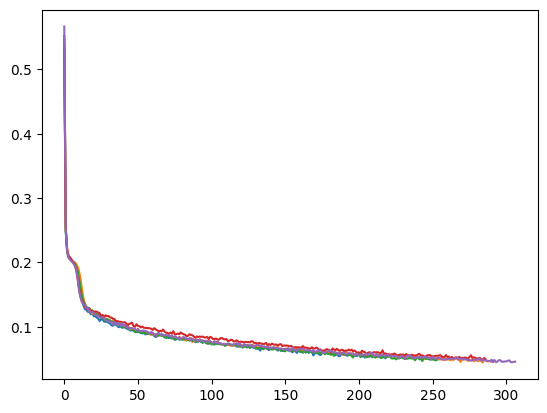

In [21]:
all_scores=[]
all_preds=[]
conf_mat=[]
reports=[]
roc=[]
roc_auc=[]
tprs=[]
acc_scores=[]
sens_scores=[]
spec_scores=[]
mcc_scores=[]

for i,(train_index,test_index) in enumerate(kf.split(training_data)):
    x_train, x_test=training_data[train_index],training_data[test_index]
    y_train, y_test=training_label[train_index],training_label[test_index]
    y_train=np.asarray(y_train)
    mode1= CapsNet(input_shape=(55,20),n_class=2,num_routing=3)
    mode1.compile(optimizers.RMSprop(lr=0.0001),loss=margin_loss,metrics=['acc'])
    call=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=25)]
    history=mode1.fit(x=x_train,y=y_train,batch_size=128,epochs=600,validation_data=[x_test,y_test], callbacks=call)
    mode1.save('./TCap'+str(i)+'Lastepoch_new.h5') # save your model
    plt.plot(history.history['loss'],label='train'+str(i))
    scores=mode1.evaluate(x_test,y_test)
    all_scores.append(scores)
    pred=mode1.predict(x_test)
    all_preds.append(pred)
    y_prediction=np.argmax(pred,1)
    y_true=np.argmax(y_test,1)
    conf= metrics.confusion_matrix(y_true,y_prediction)
    conf_mat.append(conf)
    report=metrics.classification_report(y_true,y_prediction)
    reports.append(report)
    fpr,tpr,_=metrics.roc_curve(y_true=y_test[:,1],y_score=pred[:,1])
    roc.append([fpr,tpr])
    roc_auc.append(metrics.auc(fpr,tpr))
    tpr=interp(base_fpr,fpr,tpr)
    tpr[0]=0.0
    tprs.append(tpr)

    # calculate metrics
    acc_scores.append(metrics.accuracy_score(y_true, y_prediction))
    sens_scores.append(metrics.recall_score(y_true, y_prediction))
    spec_scores.append(metrics.precision_score(y_true, y_prediction))
    mcc_scores.append(metrics.matthews_corrcoef(y_true, y_prediction))

# calculate mean and standard deviation of metrics
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_sens = np.mean(sens_scores)
std_sens = np.std(sens_scores)
mean_spec = np.mean(spec_scores)
std_spec = np.std(spec_scores)
mean_mcc = np.mean(mcc_scores)
std_mcc = np.std(mcc_scores)

print(f"Average accuracy: {mean_acc:.4f} +/- {std_acc:.4f}")
print(f"Average sensitivity: {mean_sens:.4f} +/- {std_sens:.4f}")
print(f"Average specificity: {mean_spec:.4f} +/- {std_spec:.4f}")
print(f"Average MCC: {mean_mcc:.4f} +/- {std_mcc:.4f}")


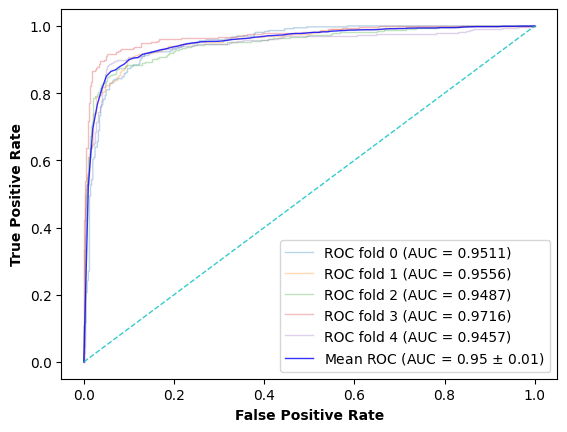

In [22]:
fprs=[]
for i,[fpr,tpr] in enumerate(roc):
    fprs.append(fpr)
    plt.plot(fpr,tpr,label='ROC fold {} (AUC = {:.4f})'.format(i,roc_auc[i]),lw=1,alpha=0.3)
plt.plot(base_fpr, np.average(tprs,axis=0),
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(roc_auc),np.std(roc_auc)),lw=1,alpha=.8,color='b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, alpha=.8,color='c')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc=4)
plt.xlabel('False Positive Rate',fontweight='bold')
plt.ylabel('True Positive Rate',fontweight='bold')
plt.savefig( 'five_fold_roc_capsulnet_lstm.pdf') # use your own dictionay 
plt.show()

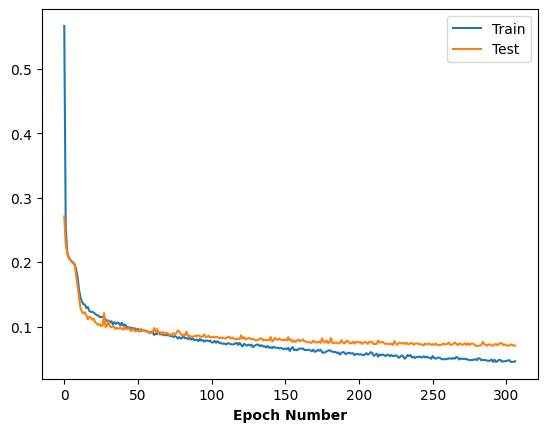

In [23]:
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
plt.xlabel('Epoch Number',fontweight='bold')
pyplot.savefig('train_loss_lstm.pdf')
pyplot.show()

In [24]:
def ROC(temp, OutputDir):
    validation_result = temp;
    for x in [validation_result]:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0
        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))

            i += 1

        print;

        plt.plot([0, 1], [0, 1], linestyle='--', lw=1,color='c' , alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate',fontweight='bold')
        plt.ylabel('True Positive Rate',fontweight='bold')
        plt.legend(loc="lower right")
       # plt.savefig( OutputDir + '/'+'roc_capsulnet_independet.pdf') #save the figure in your file path
        plt.show()
        plt.close('all')
        
        
         #************************** Precision Recall Curve*********************************
        j=0
        prs = []
        pre_aucs = []
        mean_recal= np.linspace(0, 1, 100)
        for val in x:
            pre = val['prec']
            rec = val['reca']
            prs.append(interp(mean_recal, rec, pre))
            prs[-1][0] = 0.0
            p_r_auc = auc(rec, pre)
            pre_aucs.append(p_r_auc)
            plt.plot(rec, pre, lw=1, alpha=0.3,label='PRC fold %d (AUC = %0.3f)' % (j+1, p_r_auc))

            j += 1

        print;

        #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)

        mean_pre = np.mean(prs, axis=0)
        mean_pre[-1] = 1.0
        mean_auc = auc(mean_recal, mean_pre)
        std_auc = np.std(pre_aucs)
        plt.plot(mean_recal, mean_pre, color='b',
                 label=r'Mean PRC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_pre = np.std(prs, axis=0)
        pre_upper = np.minimum(mean_pre + std_pre, 1)
        pre_lower = np.maximum(mean_pre - std_pre, 0)
        plt.fill_between(mean_recal, pre_lower, pre_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([0.0, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall',fontweight='bold')
        plt.ylabel('Precision',fontweight='bold')
        plt.title('Prc capsulnet',fontweight='bold')
        plt.legend(loc="lower right")
        #plt.savefig( OutputDir + '/' +'PRC_capsulnet_lstmcaps_ind.pdf') ## save file on your own path
        plt.show()
        plt.close('all')

        
def cal(X,y, model):
    pred_y =  model.predict(X)[::,1]
    ROCArea = roc_auc_score(y, pred_y)
    print(ROCArea)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  #so the array is increasing (you won't get negative AUC)
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    
    return { 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}

In [25]:
#independent test 
#ACP212
positive_ind_data=read_fasta('acp_test_212_padded.fasta')
negative_ind_data=read_fasta('neg_test_212_padded.fasta')
all_ind_data=positive_ind_data+negative_ind_data

In [26]:
all_ind_onehot=onehot(all_ind_data)

In [27]:
label_ind=len(positive_ind_data)*[1]+ len(negative_ind_data)*[0]
label_ind=np.asarray(label_ind)

In [28]:

#Plot the AUC-ROC curve AND calculate the AUC-ROC score, precision-recall curve and calculate the AUC-PR score
import warnings
from keras.models import load_model
warnings.filterwarnings("ignore")
OutputDir="/home/sadik/TCap/indepedent_result" # give your own path in your personal computer
validation_result=[]
for i in range(5):
        mode1.load_weights('TCap'+str(i+0)+'Lastepoch_new'+'.h5')  # load model weights for five folds
        validation_result.append(cal(all_ind_onehot,label_ind, mode1))
        #validation_result.append(cal(data_papaya,training_label[:,1], mode1))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir) 

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
import warnings
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef
warnings.filterwarnings("ignore")

OutputDir="/home/sadik/TCap/indepedent_result" # give your own path in your personal computer
validation_result = []

# Define lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
mcc_scores = []

for i in range(5):
    mode1 = load_model('TCap'+ str(i)+'Lastepoch_new'+'.h5')  # load model weights for five folds
    predictions = mode1.predict(all_ind_onehot)
    
    # Perform thresholding if needed
    # thresholded_predictions = (predictions > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(label_ind, predictions)
    precision = precision_score(label_ind, predictions)
    recall = recall_score(label_ind, predictions)
    mcc = matthews_corrcoef(label_ind, predictions)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    mcc_scores.append(mcc)

    # validation_result.append(cal(all_ind_onehot,label_ind, mode1))
    # validation_result.append(cal(data_papaya,training_label[:,1], mode1))
    # temp_dict = (validation_result)
    
# Calculate average scores
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_mcc = sum(mcc_scores) / len(mcc_scores)

# Print or save the average scores
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average MCC:", average_mcc)